In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from collections import Counter
from sklearn.metrics import mean_absolute_error,mean_squared_error,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import statsmodels.api as sm

import math


# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.stats import wasserstein_distance
from scipy.stats import entropy

import random


# Load Dataset and prepare it for random forest

In [ ]:
def one_week_shuffle(data_external_2015, data_actor_2015, data_global_2015):
    """
    This function is only for train data. It is used to recreate the structure of the test data
    It will remove the last day of each week, and shuffle the dataset week-wise

    data_external_2015: the loaded data_external dataset
    data_actor_2015: the loaded data_actor dataset
    data_global_2015: the loaded data_global dataset

    """

    # shuffle by week
    week_order = np.arange(0,max(data_external_2015["week"])+1,1)

    seed_value = 42
    the_shuffler = np.random.default_rng(seed_value)

    the_shuffler.shuffle(week_order)

    data_external = pd.DataFrame(columns=list(data_external_2015.columns))
    data_actor = data_actor_2015.copy()
    data_global = pd.DataFrame(columns=list(data_global_2015.columns))

    for i in week_order:
        for j in [0, 1, 2, 3, 4, 5]:
            # it is said that frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
            # however we kept it because it has not been removed yet, and is many times faster
            new_row_external = data_external_2015.loc[(i * 6) + j].copy()
            data_external = data_external.append(new_row_external, ignore_index=True)
            # data_external = pd.concat([data_external, new_row_external], ignore_index=True)

            new_row_actor = data_actor_2015.loc[(i * 6) + j].copy()
            data_actor = data_actor.append(new_row_actor, ignore_index=True)
            # data_actor = pd.concat([data_actor, new_row_actor], ignore_index=True)

            new_row_global = data_global_2015.loc[(i * 6) + j].copy()
            data_global = data_global.append(new_row_global, ignore_index=True)
            # data_global = pd.concat([data_global, new_row_global], ignore_index=True)

    # putting week and weekday back into integers
    data_external["week"] = data_external["week"].astype(int)
    data_actor["week"] = data_actor["week"].astype(int)
    data_global["week"] = data_global["week"].astype(int)
    data_external["weekday"] = data_external["weekday"].astype(int)
    data_actor["weekday"] = data_actor["weekday"].astype(int)
    data_global["weekday"] = data_global["weekday"].astype(int)

    # dropping year	month	day
    data_external = data_external.drop(columns=["year", "month", "day"])
    data_actor = data_actor.drop(columns=["year", "month", "day"])
    data_global = data_global.drop(columns=["year", "month", "day"])

    return data_external, data_actor, data_global


In [ ]:
def get_wasserstein(data_actor, dataframe_external_global):
    data_actor_nb_t=pd.DataFrame(data_actor.groupby(["week","weekday"])['nb_transactions'].apply(list).reset_index())
    global_max = max(data_actor_nb_t['nb_transactions'].apply(lambda x: max(x)))

    bin_count=[]
    single_bin_size = min(200, int(np.floor(global_max*0.001)*10)) #170
    for j in range(data_actor_nb_t['nb_transactions'].shape[0]):
      values = []
      for i in range(1, int(np.ceil(global_max / single_bin_size) + 1)):
          num = 0
          previous_i = max(0, i - 1)
          for x in data_actor_nb_t['nb_transactions'].iloc[j]:
              if x >= (previous_i * single_bin_size) and x < (i * single_bin_size):
                  num += 1
          values.append(num/len(data_actor_nb_t['nb_transactions'].iloc[j]))
      bin_count.append(values)
    bin_count=np.array(bin_count)

    list_wass = [0] #[np.nan]
    # list_kl = [0] #[np.nan]
    for i in range(len(bin_count)-1):
        list_wass.append(wasserstein_distance(bin_count[i],bin_count[i+1]))
        # list_kl.append(entropy(bin_count[i],bin_count[i+1]))

    dataframe_external_global['Wasserstein'] = list_wass

    return dataframe_external_global

In [39]:
def get_data_ready(data, max_lag=1):
    """
    data : The dataframe the we want to extract X and y from
    max_lag : integer between 1 and 6. Maximum lag that you want. each column will have lag 1 to max_lag.

    """
    if max_lag < 1 or max_lag > 6:
        print("ERROR : max_lag has to be an integer included between 1 and 6.")
        return
    elif max_lag == 1:
        # preparing the input and the output. The first output is taken out, and the last input is taken out.
        # this way the first y value is of the second day, and the first input value is of the first day, creating the 1 day lag
        X = data.drop(columns=["week"]).iloc[:-1]
        y = data["PriceUSD"].iloc[1:]
    else:
        # explanation for the example of max_lag=6 :
        # creating the dataframe with the lag from 1 to 6.
        # first we get the dataframe of all the data for a 6 day lag, the same way we did above for the 1 day lag random forest, but
        # instead of taking off 1 row at the end we take off 6

        # we then shift the data 1 by 1, taking off 1 line at the start and taking off one line less at the end.
        # each new_X dataset concatenated to the previous ones has one less lag because
        # the first day of the new_X dataframe is one day closer to the first y value
        # it starts by having lag 6, then 5 etc
        # its why we take off the last 6 rows because we have lag 6, and as we get a smaller lag we remove less rows at the end
        # because the last row of new_X has a smaller lag for the last value in y
        X = data.drop(columns=["week"]).iloc[:-max_lag]
        y = data["PriceUSD"].iloc[max_lag:]
        suffix = "_lag_" + str(max_lag)
        X = X.add_suffix(suffix)

        for i in range(1,max_lag):
            new_X = data.drop(columns=["week"]).iloc[i:-max_lag+i]
            # new_y = data["PriceUSD"].iloc[i:]
            suffix = "_lag_" + str(max_lag-i)
            new_X = new_X.add_suffix(suffix)
            new_X = new_X.reset_index(drop=True)

            X = pd.concat([X, new_X], axis=1)

        col_names = ["weekday_lag_6", "weekday_lag_5", "weekday_lag_4", "weekday_lag_3", "weekday_lag_2", "weekday_lag_1"]
        rows_to_remove = []
        for i in range(X.shape[0]):
            for the_col in col_names[-max_lag+1:]:
                if X[the_col].iloc[i] == 0:
                    rows_to_remove.append(i)
                    break
    print("rows to remove :", rows_to_remove)
    print("column names where zeroes were checked :", col_names[-max_lag:-1])
    X.drop(index=rows_to_remove, inplace=True)

    y = y.reset_index(drop=True)
    y.drop(index=rows_to_remove, inplace=True)
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    return X, y

rows to remove : [5, 11, 17, 23, 29, 35, 41, 47, 53, 59, 65, 71, 77, 83, 89, 95, 101, 107, 113, 119, 125, 131, 137, 143, 149, 155, 161, 167, 173, 179, 185, 191, 197, 203, 209, 215, 221, 227, 233, 239, 245, 251, 257, 263, 269, 275, 281, 287, 293, 299, 305]
column names where zeroes were checked : ['weekday_lag_2']
(259, 200) (259,)


In [ ]:
def load_clean_and_prepare_data(data_external_path, data_actor_path, data_global_path, data_type="train", max_lag=2, train_test_split=0.8):
    """
    data_external_path: path to data_external file
    data_actor_path: path to data_actor file
    data_global_path: path to data_global file
    data_type: str : 'train' if loading the 2015 train data,
                      'test' if loading the task 1 test data
                      'for_excel' if loading test data and preparing for prediction of missing values for the excel
    max_lag : int between 1 and 6 : it is the maximum number of days we look at before the day we want to predict
    train_test_split : float : amount of data we want for training, remainder is for testing

    """
    if data_type=="train":
        data_external_2015 = pd.read_csv(data_external_path)
        data_actor_2015 = pd.read_csv(data_actor_path)
        data_global_2015 = pd.read_csv(data_global_path)

        # removing the last day of each week
        data_external_2015 = data_external_2015[data_external_2015["weekday"] != 6].reset_index(drop=True)
        data_actor_2015 = data_actor_2015[data_actor_2015["weekday"] != 6].reset_index(drop=True)
        data_global_2015 = data_global_2015[data_global_2015["weekday"] != 6].reset_index(drop=True)

        data_external, data_actor, data_global = one_week_shuffle(data_external_2015, data_actor_2015, data_global_2015)

        # drop columns we wont use
        data_global.drop(columns=["xxxx","volume_without_self","original order"], inplace=True)
        data_actor.drop(columns=["identity"], inplace=True)
        # data_external.drop(columns=["week"], inplace=True)

        # merge data_external and data_global
        dataframe_external_global = pd.merge(data_external, data_global, on=['week', 'weekday'])

        # creating new column div_HashRate_newly_created_coins
        dataframe_external_global['div_HashRate_newly_created_coins'] = dataframe_external_global['HashRate']/dataframe_external_global['newly_created_coins']

        # grouping actors
        data_actor_grouped=data_actor.groupby(["week","weekday"]).agg(['mean', 'std','skew','min','sum','median','max','var'])
        data_actor_grouped.columns = [f'{col}_{agg}' for col, agg in data_actor_grouped.columns]

        # get wasserstein
        dataframe_external_global = get_wasserstein(data_actor, dataframe_external_global)

        # merging the 3 datasets
        dataframe_external_global_actor = pd.merge(dataframe_external_global, data_actor_grouped, on=['week', 'weekday'])

        # getting data ready
        X, y = get_data_ready(dataframe_external_global_actor, max_lag=max_lag)

        # splitting the data
        split = 0.8
        X_train = X.iloc[:math.floor(X.shape[0]*split)]
        X_test = X.iloc[:math.ceil(X.shape[0]*(1-split))]
        y_train = y.iloc[:math.floor(y.shape[0]*split)]
        y_test = y.iloc[:math.ceil(y.shape[0]*(1-split))]

        return X_train, X_test, y_train, y_test

    elif data_type=="test":
        pass
    elif data_type=="for_excel":
        pass
    else:
        print("data_type value not recognized. Please read the description.")
        return




In [2]:
# # loading 2015 data
# data_external_2015 = pd.read_csv("/content/external.csv")
# data_actor_2015 = pd.read_csv("/content/by_actor.csv")
# data_global_2015 = pd.read_csv("/content/global.csv")

In [3]:
# data_actor_2015.shape

(35950, 16)

In [4]:
# data_external_2015.head(8)

,week,weekday,year,month,day,PriceUSD,HashRate
0,0,0,2015,1,2,315.942732,333345.017260
1,0,1,2015,1,3,285.647310,327284.198765
2,0,2,2015,1,4,263.334575,347486.927083
3,0,3,2015,1,5,275.003852,315162.561773
4,0,4,2015,1,6,287.549521,319203.107437
5,0,5,2015,1,7,297.535565,282838.196463
6,0,6,2015,1,8,284.342392,296980.106286
7,1,0,2015,1,9,292.501115,282838.196463


In [5]:
# # removing the last day of each week

# data_external_2015 = data_external_2015[data_external_2015["weekday"] != 6].reset_index(drop=True)
# data_actor_2015 = data_actor_2015[data_actor_2015["weekday"] != 6].reset_index(drop=True)
# data_global_2015 = data_global_2015[data_global_2015["weekday"] != 6].reset_index(drop=True)


In [6]:
# data_external_2015.head(8)

,week,weekday,year,month,day,PriceUSD,HashRate
0,0,0,2015,1,2,315.942732,333345.017260
1,0,1,2015,1,3,285.647310,327284.198765
2,0,2,2015,1,4,263.334575,347486.927083
3,0,3,2015,1,5,275.003852,315162.561773
4,0,4,2015,1,6,287.549521,319203.107437
5,0,5,2015,1,7,297.535565,282838.196463
6,1,0,2015,1,9,292.501115,282838.196463
7,1,1,2015,1,10,276.230532,296980.106286


In [7]:
# max(data_external_2015["week"])

51

In [9]:
# # shuffle by week
# # max(data_external["week"])
# week_order = np.arange(0,max(data_external_2015["week"])+1,1)

# seed_value = 42
# the_shuffler = np.random.default_rng(seed_value)

# the_shuffler.shuffle(week_order)
# # week_order

# data_external = pd.DataFrame(columns=list(data_external_2015.columns))
# data_actor = data_actor_2015.copy() #pd.DataFrame(columns=list(data_actor_2015.columns))
# data_global = pd.DataFrame(columns=list(data_global_2015.columns))

# for i in week_order:
#     for j in [0, 1, 2, 3, 4, 5]:
#         # it is said that frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
#         # however we kept it because it has not been removed yet, and is many times faster
#         new_row_external = data_external_2015.loc[(i * 6) + j].copy()
#         data_external = data_external.append(new_row_external, ignore_index=True)
#         # data_external = pd.concat([data_external, new_row_external], ignore_index=True)

#         new_row_actor = data_actor_2015.loc[(i * 6) + j].copy()
#         data_actor = data_actor.append(new_row_actor, ignore_index=True)
#         # data_actor = pd.concat([data_actor, new_row_actor], ignore_index=True)

#         new_row_global = data_global_2015.loc[(i * 6) + j].copy()
#         data_global = data_global.append(new_row_global, ignore_index=True)
#         # data_global = pd.concat([data_global, new_row_global], ignore_index=True)

# # putting week and weekday back into integers
# data_external["week"] = data_external["week"].astype(int)
# data_actor["week"] = data_actor["week"].astype(int)
# data_global["week"] = data_global["week"].astype(int)
# data_external["weekday"] = data_external["weekday"].astype(int)
# data_actor["weekday"] = data_actor["weekday"].astype(int)
# data_global["weekday"] = data_global["weekday"].astype(int)

# # dropping year	month	day
# data_external = data_external.drop(columns=["year", "month", "day"])
# data_actor = data_actor.drop(columns=["year", "month", "day"])
# data_global = data_global.drop(columns=["year", "month", "day"])

<ipython-input-9-4003a672bf37>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_external = data_external.append(new_row_external, ignore_index=True)
<ipython-input-9-4003a672bf37>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_actor = data_actor.append(new_row_actor, ignore_index=True)
<ipython-input-9-4003a672bf37>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_global = data_global.append(new_row_global, ignore_index=True)


In [10]:
# data_external.head(8)

,week,weekday,PriceUSD,HashRate
0,27,0,285.558781,378191.272302
1,27,1,293.917454,365703.823777
2,27,2,311.481880,342767.691987
3,27,3,292.649224,375774.951216
4,27,4,287.740951,365618.871453
5,27,5,285.922885,388470.050919
6,7,0,245.530775,349162.732810
7,7,1,245.596003,313804.481386


In [11]:
# week_order

array([27,  7, 47, 38, 51, 17,  5, 49, 34, 23, 39, 29, 20, 18, 24, 37, 46,
       41,  4, 25, 31, 26, 40,  9, 48, 21, 28, 42, 16, 44, 32, 15,  3, 30,
       10, 45,  6, 11, 22, 19, 35,  0, 12, 43, 14, 50,  2, 36, 33,  1, 13,
        8])

In [12]:
# my_list = list(data_global["original order"])

# # indices in ascending order
# indices_in_order = sorted(range(len(my_list)), key=lambda i: my_list[i])

In [13]:
# data_external.iloc[indices_in_order]['PriceUSD']

246    315.942732
247    285.647310
248    263.334575
249    275.003852
250    287.549521
          ...    
25     418.221532
26     422.705895
27     421.052880
28     431.340021
29     426.043647
Name: PriceUSD, Length: 312, dtype: float64

In [14]:
# data_external.head(5)

,week,weekday,PriceUSD,HashRate
0,27,0,285.558781,378191.272302
1,27,1,293.917454,365703.823777
2,27,2,311.481880,342767.691987
3,27,3,292.649224,375774.951216
4,27,4,287.740951,365618.871453


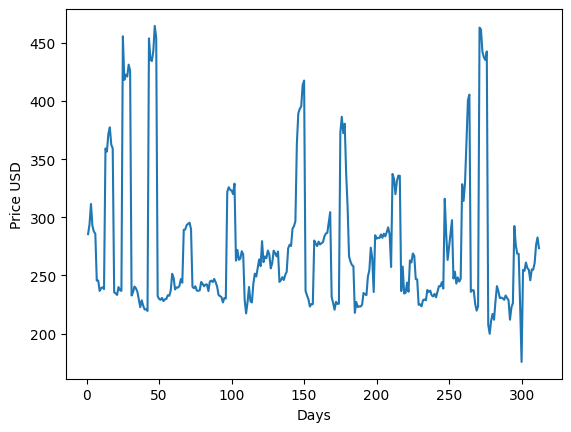

In [16]:
# # non ordered data
# plt.plot(range(1,data_external.shape[0]+1),data_external['PriceUSD'])
# plt.ylabel("Price USD")
# plt.xlabel("Days")
# plt.show()

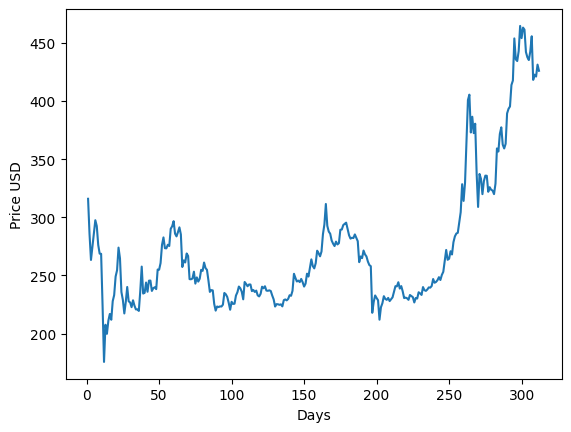

In [17]:
# #reordered prices (to check all is well)
# plt.plot(range(1,data_external.shape[0]+1),data_external.iloc[indices_in_order]['PriceUSD'])
# plt.ylabel("Price USD")
# plt.xlabel("Days")
# plt.show()
# # plt.savefig("priceusd.png")

In [18]:
# # drop columns we wont use
# data_global.drop(columns=["xxxx","volume_without_self","original order"], inplace=True)
# data_actor.drop(columns=["identity"], inplace=True)
# # data_external.drop(columns=["week"], inplace=True)

In [19]:
# (data_global['total_received_satoshi']-data_global['total_sent_satoshi']==data_global['newly_created_coins']).all()

True

In [20]:
# # merge the two datasets
# dataframe_external_global = pd.merge(data_external, data_global, on=['week', 'weekday'])

In [21]:
# # creating new column div_HashRate_newly_created_coins
# dataframe_external_global['div_HashRate_newly_created_coins'] = dataframe_external_global['HashRate']/dataframe_external_global['newly_created_coins']

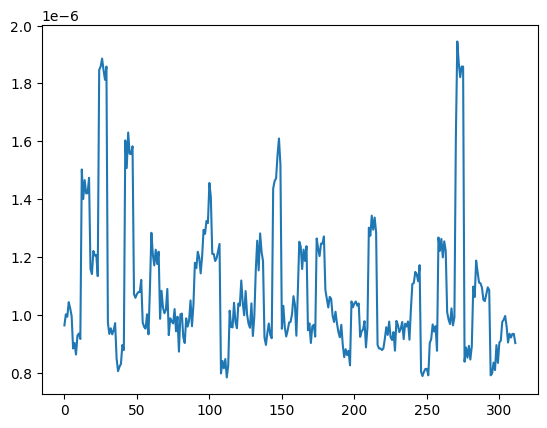

In [22]:
# plt.plot(dataframe_external_global['div_HashRate_newly_created_coins'])
# plt.show()

In [23]:
# # grouping actors
# data_actor_grouped=data_actor.groupby(["week","weekday"]).agg(['mean', 'std','skew','min','sum','median','max','var'])
# data_actor_grouped.columns = [f'{col}_{agg}' for col, agg in data_actor_grouped.columns]

# wasserstein

In [27]:
data_actor_nb_t=pd.DataFrame(data_actor.groupby(["week","weekday"])['nb_transactions'].apply(list).reset_index())
data_actor_nb_t.head()

,week,weekday,nb_transactions
0,0,0,"[962, 3, 86, 10, 31, 1, 3, 3, 4, 58, 13, 7, 65..."
1,0,1,"[943, 0, 77, 15, 1, 47, 0, 7, 7, 3, 55, 27, 16..."
2,0,2,"[1059, 2, 82, 23, 4, 90, 1, 9, 21, 6, 51, 19, ..."
3,0,3,"[995, 3, 69, 18, 1, 48, 3, 13, 9, 4, 61, 50, 1..."
4,0,4,"[1011, 6, 86, 30, 0, 33, 3, 8, 14, 4, 56, 42, ..."


In [28]:
global_max = max(data_actor_nb_t['nb_transactions'].apply(lambda x: max(x)))
print(global_max)

75714


In [30]:
bin_count=[]
single_bin_size = min(200, int(np.floor(global_max*0.001)*10)) #170
for j in range(data_actor_nb_t['nb_transactions'].shape[0]):
  values = []
  for i in range(1, int(np.ceil(global_max / single_bin_size) + 1)):
      num = 0
      previous_i = max(0, i - 1)
      for x in data_actor_nb_t['nb_transactions'].iloc[j]:
          if x >= (previous_i * single_bin_size) and x < (i * single_bin_size):
              num += 1
      values.append(num/len(data_actor_nb_t['nb_transactions'].iloc[j]))
  bin_count.append(values)

In [31]:
bin_count=np.array(bin_count)

In [32]:
bin_count[0][0]

0.9

In [33]:
bin_count.shape

(312, 379)

In [34]:
list_wass = [0] #[np.nan]
# list_kl = [0] #[np.nan]
for i in range(len(bin_count)-1):
    list_wass.append(wasserstein_distance(bin_count[i],bin_count[i+1]))
    # list_kl.append(entropy(bin_count[i],bin_count[i+1]))

In [35]:
dataframe_external_global['Wasserstein'] = list_wass
# dataframe_external_global['KL'] = list_kl

# Merging the three datasets

In [36]:
dataframe_external_global_actor = pd.merge(dataframe_external_global, data_actor_grouped, on=['week', 'weekday'])

In [37]:
dataframe_external_global_actor.columns

Index(['week', 'weekday', 'PriceUSD', 'HashRate', 'total_fee',
       'total_received_satoshi', 'total_sent_satoshi', 'mean_fee_satoshi',
       'mean_feeUSD', 'mean_fee_for100',
       ...
       'nb_spent_max', 'nb_spent_var', 'spent_mean', 'spent_std', 'spent_skew',
       'spent_min', 'spent_sum', 'spent_median', 'spent_max', 'spent_var'],
      dtype='object', length=101)

In [38]:
dataframe_external_global_actor.shape

(312, 101)

In [40]:
dataframe_external_global_actor.head(7)

,week,weekday,PriceUSD,HashRate,total_fee,total_received_satoshi,total_sent_satoshi,mean_fee_satoshi,mean_feeUSD,mean_fee_for100,...,nb_spent_max,nb_spent_var,spent_mean,spent_std,spent_skew,spent_min,spent_sum,spent_median,spent_max,spent_var
0,27,0,285.558781,378191.272302,3862578316,185767132763478,185374632763478,19210.117452,5.485618e+06,12.524902,...,87059,7.575098e+07,9.478750e+10,3.863288e+11,6.892826,2722076,9478749998960,4.737324e+09,3377122565552,1.492500e+23
1,27,1,293.917454,365703.823777,3873824315,129369613082930,129004613082930,20713.201201,6.087971e+06,15.548947,...,83557,6.984944e+07,5.134520e+10,2.007997e+11,6.655813,0,5134519910938,3.025386e+09,1701494168065,4.032051e+22
2,27,2,311.481880,342767.691987,4395279533,128039344907800,127694344907800,22261.906617,6.934180e+06,19.009550,...,153153,2.342601e+08,6.456295e+10,3.505264e+11,8.849047,0,6456295222864,3.336273e+09,3378126205753,1.228688e+23
3,27,3,292.649224,375774.951216,3298487518,135645763470993,135285763470993,19466.994322,5.697001e+06,15.012109,...,81259,6.599055e+07,6.625365e+10,2.887965e+11,8.028825,0,6625365228189,4.529761e+09,2696238573786,8.340344e+22
4,27,4,287.740951,365618.871453,2919416927,130214320430390,129856820430390,23748.419251,6.833392e+06,3.666069,...,48080,2.347051e+07,7.402440e+10,3.664086e+11,8.649206,0,7328415472919,3.839879e+09,3504822537083,1.342553e+23
5,27,5,285.922885,388470.050919,2611471636,125028896089787,124638896089787,22546.700937,6.446618e+06,4.054823,...,49565,2.466255e+07,7.595684e+10,4.028243e+11,9.133554,0,7595683728173,2.891879e+09,3939819533879,1.622674e+23
6,7,0,245.530775,349162.732810,1491995408,77469954907914,77074954907914,15375.372617,3.775127e+06,0.859620,...,35200,1.333456e+07,3.920746e+10,1.764250e+11,8.272356,0,3803123581258,2.305714e+09,1653217094513,3.112579e+22


In [41]:
#values of first row to manually verify it worked well
for i in X.columns:
    print(f"{i} : {X.iloc[0][i]}")

weekday_lag_2 : 0
PriceUSD_lag_2 : 285.558780829924
HashRate_lag_2 : 378191.27230166
total_fee_lag_2 : 3862578316
total_received_satoshi_lag_2 : 185767132763478
total_sent_satoshi_lag_2 : 185374632763478
mean_fee_satoshi_lag_2 : 19210.1174516338
mean_feeUSD_lag_2 : 5485617.60022556
mean_fee_for100_lag_2 : 12.5249016934168
nb_transactions_lag_2 : 201070
nb_payments_lag_2 : 934976
mean_nb_inputs_lag_2 : 2.30095986472373
mean_nb_outputs_lag_2 : 4.65000248669618
nb_mining_lag_2 : 157
total_mining_satoshi_lag_2 : 396362578316
newly_created_coins_lag_2 : 392500000000
self_spent_satoshi_lag_2 : 14706190362840
total_received_lag_2 : 185767132763478
div_HashRate_newly_created_coins_lag_2 : 9.63544642806777e-07
Wasserstein_lag_2 : 0.0
received_mean_lag_2 : 138147058663.7
received_std_lag_2 : 503062791491.00366
received_skew_lag_2 : 4.797213832053601
received_min_lag_2 : 3107553
received_sum_lag_2 : 13814705866370
received_median_lag_2 : 4861017573.5
received_max_lag_2 : 3299690041477
received_va

In [42]:
# checking to make sure that the only lag that has weekday 0 is the one that is the biggest lag we chose
the_list = ["weekday_lag_6", "weekday_lag_5", "weekday_lag_4", "weekday_lag_3", "weekday_lag_2", "weekday_lag_1"]
X[the_list[6-max_lag:]].head(6)

,weekday_lag_2,weekday_lag_1
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5
5,0,1


In [43]:
# splitting the data
split = 0.8
X_train = X.iloc[:math.floor(X.shape[0]*split)]
X_test = X.iloc[:math.ceil(X.shape[0]*(1-split))]
y_train = y.iloc[:math.floor(y.shape[0]*split)]
y_test = y.iloc[:math.ceil(y.shape[0]*(1-split))]

In [44]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(207, 200) (52, 200) (207,) (52,)


# Random Forest

In [45]:
# training with 10 000 trees
model = RandomForestRegressor(n_estimators = 10000, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10000, random_state=42)

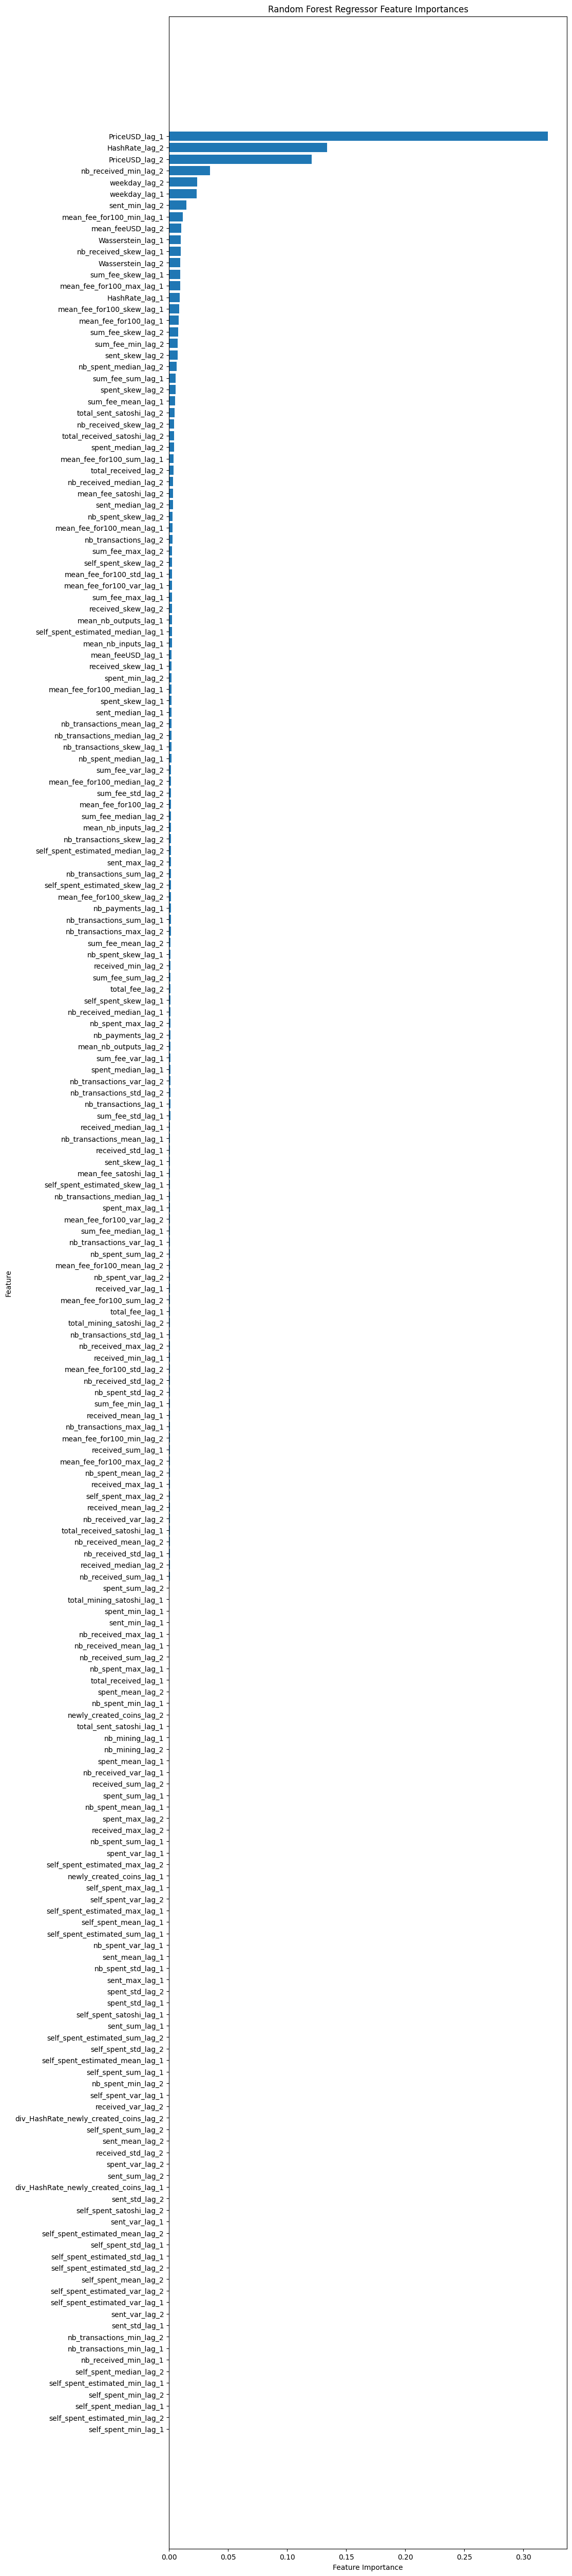

In [46]:
# plotting the feature importances of all the features
feature_importances = model.feature_importances_
feature_names = X.columns

indices = np.argsort(feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 64))
plt.barh(range(len(indices)), feature_importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
# plt.xlim(right=0.05)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Regressor Feature Importances")
plt.show()

In [47]:
# i print this in case i want to have the values after the colab disconnects
feature_importances

array([2.38672180e-02, 1.20750929e-01, 1.33877899e-01, 1.27904890e-03,
       4.21368480e-03, 4.54056063e-03, 3.40333770e-03, 1.02861016e-02,
       1.77192654e-03, 2.80973565e-03, 1.13610482e-03, 1.72065166e-03,
       1.12643662e-03, 5.15768821e-04, 8.20741335e-04, 5.24725440e-04,
       2.60273946e-04, 3.64945711e-03, 2.84559616e-04, 9.71301496e-03,
       6.29468015e-04, 2.73027313e-04, 2.34827241e-03, 1.43200703e-03,
       4.40470626e-04, 5.92047742e-04, 4.20683442e-04, 2.89909721e-04,
       6.10953057e-04, 7.73258594e-04, 4.44528215e-03, 3.45748558e-02,
       5.44376715e-04, 3.46895613e-03, 7.96371766e-04, 6.26851493e-04,
       1.45162467e-03, 1.78358660e-03, 7.71676411e-03, 7.40211878e-03,
       1.40100837e-03, 1.74752110e-03, 2.62573860e-03, 1.84395820e-03,
       8.59920218e-04, 7.93751266e-04, 1.49192372e-03, 7.41114497e-04,
       8.34114823e-04, 1.78542775e-03, 6.93971697e-04, 8.79583436e-04,
       1.95901039e-03, 1.04020323e-03, 1.67919655e-03, 1.07431142e-04,
      

In [48]:
# getting the mse mae rmse and r2 of the model on train data
y_pred_train = model.predict(X_train)

# Evaluate the model
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_train)
print(f"mae : {mae} mse : {mse} rmse : {rmse} r2 : {r2}")

mae : 7.669551261336326 mse : 194.29678875249925 rmse : 13.939038300847704 r2 : 0.9379530860521108


In [49]:
# getting the mse mae rmse and r2 of the model on test data
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"mae : {mae} mse : {mse} rmse : {rmse} r2 : {r2}")

mae : 13.03015868902788 mse : 485.70918648833464 rmse : 22.03881091366625 r2 : 0.9303906898262002


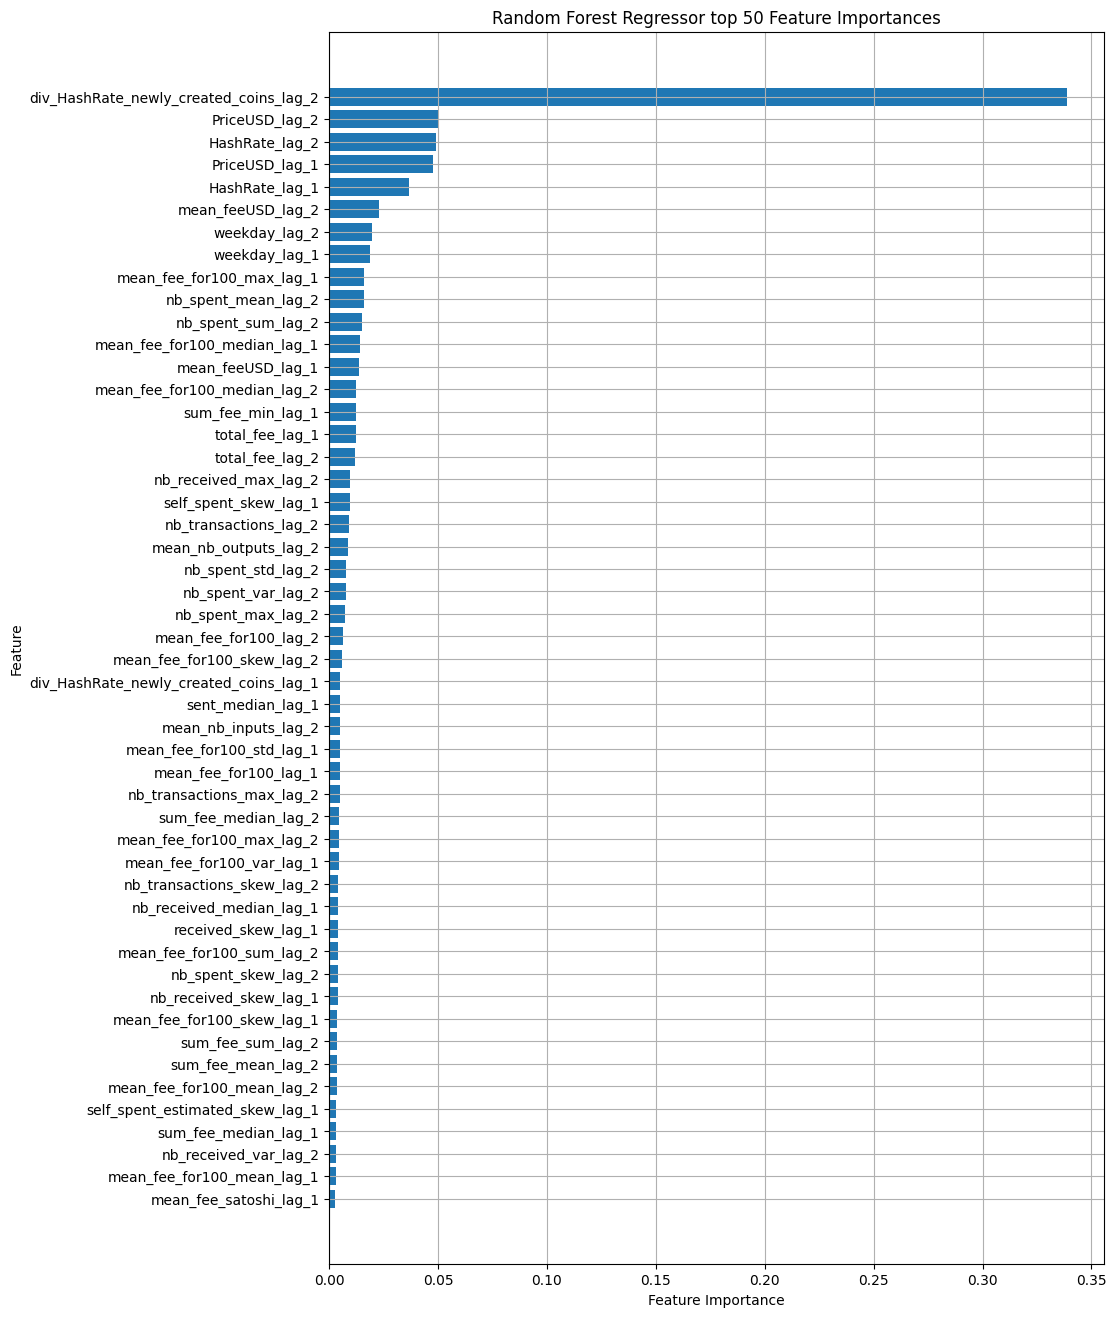

In [39]:
# plotting the feature importances of the top 50 features
feature_importances = model.feature_importances_
feature_names = X.columns

indices = np.argsort(feature_importances)

indices = indices[-50:]

# Plot feature importances
plt.figure(figsize=(10, 16))
plt.barh(range(len(indices)), feature_importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
# plt.xlim(right=0.05)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Regressor top 50 Feature Importances")
# plt.xticks(np.arange(0, 0.38, 0.02))
plt.grid()
plt.show()

# final prediction of the missing days